In [1]:
!pip install -U -q tensorflow tensorflow_datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00


#Import Libraries

In [2]:
import tensorflow_datasets
import os
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model

In [4]:
from IPython import display

#Import Dataset

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


#Preprocess Class

In [6]:
class Preprocess:
  def __init__(self,dir):
    self.dir=dir

  def load_data(self, v_split,b_size):
    self.train_ds, self.val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=b_size,
    validation_split=v_split,
    seed=0,
    output_sequence_length=16000,
    subset='both')

    self.label_names = np.array(self.train_ds.class_names)
    print("label names:", self.label_names)
    return self.train_ds, self.val_ds

  def squeeze(self,audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

  def plot(self):
    self.train_ds = self.train_ds.map(self.squeeze, tf.data.AUTOTUNE)
    self.val_ds = self.val_ds.map(self.squeeze, tf.data.AUTOTUNE)
    self.example_audio,self.example_labels=None,None
    for x,y in self.train_ds.take(1):
      self.example_audio,self.example_labels=x,y
    plt.figure(figsize=(16, 10))
    rows = 3
    cols = 3
    n = rows * cols
    for i in range(n):
      plt.subplot(rows, cols, i+1)
      audio_signal = self.example_audio[i]
      plt.plot(audio_signal)
      plt.title(self.label_names[self.example_labels[i]])
      plt.yticks(np.arange(-1.2, 1.2, 0.2))
      plt.ylim([-1.1, 1.1])

  def get_spectrogram(self,waveform):
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  def test(self):
    for i in range(3):
      label = self.label_names[self.example_labels[i]]
      waveform = self.example_audio[i]
      self.spectrogram = self.get_spectrogram(waveform)

      print('Label:', label)
      print('Waveform shape:', waveform.shape)
      print('Spectrogram shape:', spectrogram.shape)
      print('Audio playback')
      display.display(display.Audio(waveform, rate=16000))

  def make_spec_ds(self,ds):
    return ds.map(
        map_func=lambda audio,label: (self.get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

  def spec_ds(self):
    train_spectrogram_ds = self.make_spec_ds(self.train_ds)
    val_spectrogram_ds = self.make_spec_ds(self.val_ds)
    return train_spectrogram_ds,val_spectrogram_ds


In [7]:
preprocessor=Preprocess(data_dir)


In [8]:
train,test=preprocessor.load_data(v_split=0.2,b_size=64)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


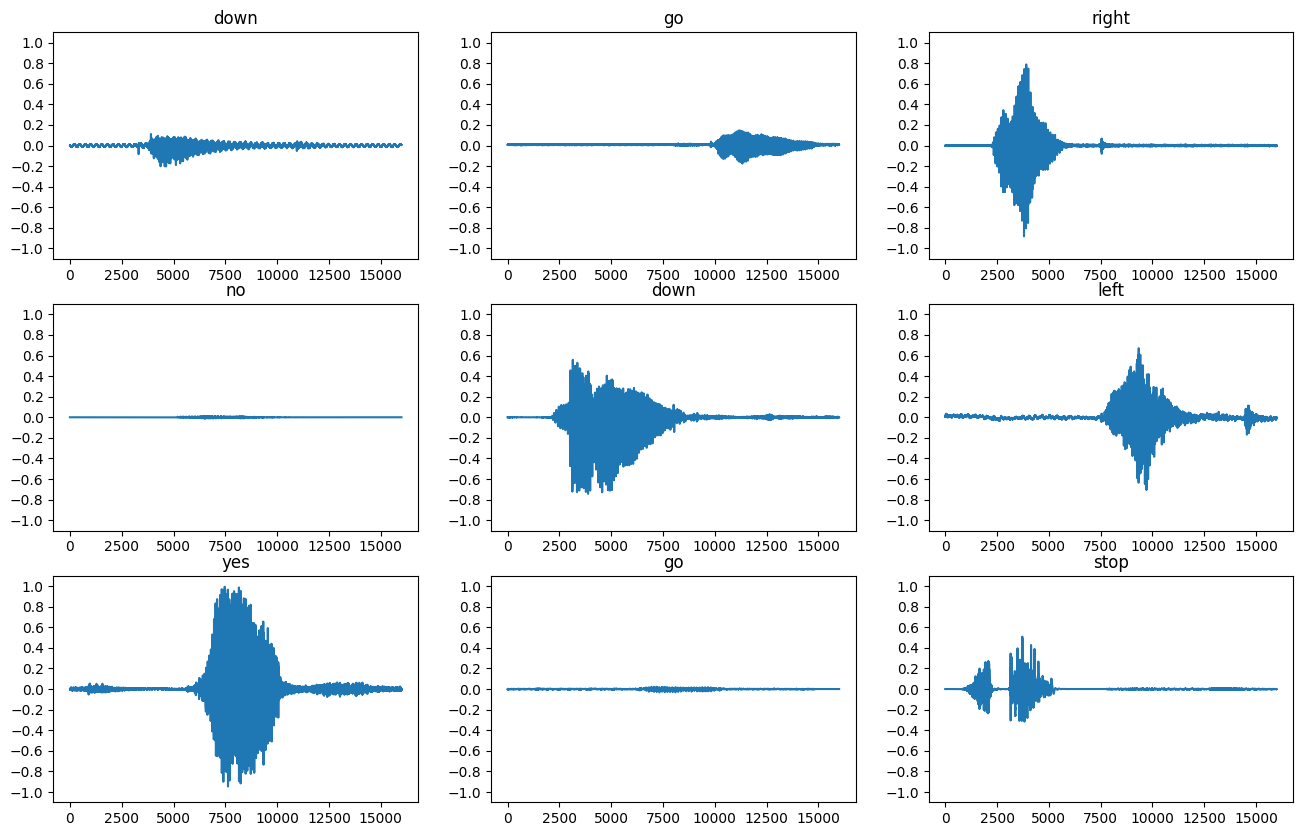

In [9]:
preprocessor.plot()

In [10]:
train_spectrogram_ds,val_spectrogram_ds=preprocessor.spec_ds()

#Training and Testing

In [11]:
def define_model(input_shape,num_labels):
  model = models.Sequential([
      layers.Input(shape=input_shape),
      layers.Resizing(32, 32),
      layers.Normalization(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels),
  ])
  return model


In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [ ]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(preprocessor.label_names)

model= define_model(input_shape,num_labels)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)         

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

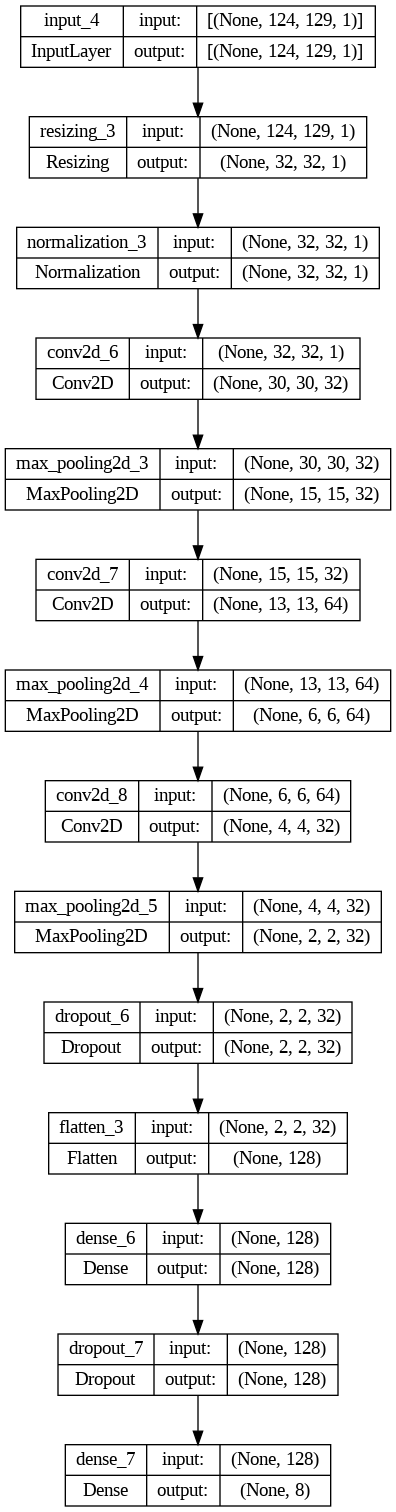

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
EPOCHS = 30
model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
100/100 [==============================] - 10s 80ms/step - loss: 1.5429 - accuracy: 0.4825 - val_loss: 0.9795 - val_accuracy: 0.6525
Epoch 2/30
100/100 [==============================] - 6s 61ms/step - loss: 1.1353 - accuracy: 0.5797 - val_loss: 0.8797 - val_accuracy: 0.6812
Epoch 3/30
100/100 [==============================] - 8s 78ms/step - loss: 0.9898 - accuracy: 0.6298 - val_loss: 0.7884 - val_accuracy: 0.7125
Epoch 4/30
100/100 [==============================] - 7s 64ms/step - loss: 0.9340 - accuracy: 0.6545 - val_loss: 0.7186 - val_accuracy: 0.7462
Epoch 5/30
100/100 [==============================] - 8s 72ms/step - loss: 0.8655 - accuracy: 0.6837 - val_loss: 0.7442 - val_accuracy: 0.7406
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.8464 - accuracy: 0.6967 - val_loss: 0.7147 - val_accuracy: 0.7588
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.8266 - accuracy: 0.7130 - val_loss: 0.6713 - val_accuracy: 0.769